# The Simpsons
![The Simpsons](https://upload.wikimedia.org/wikipedia/ru/4/42/Simpsons_cast.jpg)

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tfs
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

# Load data

In [2]:
train_dir = '../input/journeyspringfield/journey-springfield/train/simpsons_dataset'
test_dir = '../input/journeyspringfield/journey-springfield/testset'
rescale_size = 244
batch_size = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
transform = tfs.Compose([tfs.Resize((int(rescale_size * 1.25),
                                     int(rescale_size * 1.25))),
                         tfs.RandomCrop(rescale_size),
                         tfs.RandomHorizontalFlip(),
                         tfs.ToTensor(),
                         tfs.Normalize([0.485, 0.456, 0.406],
                                       [0.229, 0.224, 0.225])])

full_dataset = torchvision.datasets.ImageFolder(root=train_dir,
                                                transform=transform)

transform = tfs.Compose([tfs.Resize((int(rescale_size * 1.05),
                                     int(rescale_size * 1.05))),
                         tfs.CenterCrop(rescale_size),
                         tfs.ToTensor(),
                         tfs.Normalize([0.485, 0.456, 0.406],
                                       [0.229, 0.224, 0.225])])

test_dataset = torchvision.datasets.ImageFolder(root=test_dir,
                                                transform=transform)

train_idx, valid_idx = train_test_split(list(range(len(full_dataset))),
                                        train_size=0.8)
dataset = {'train': torch.utils.data.Subset(full_dataset, train_idx),
           'valid': torch.utils.data.Subset(full_dataset, valid_idx)}

classes = np.array(full_dataset.classes)
files = [x[0].split('/')[-1] for x in test_dataset.imgs]

dataloader = {'train': torch.utils.data.DataLoader(dataset=dataset['train'],
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=2),
              'valid': torch.utils.data.DataLoader(dataset=dataset['valid'],
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=2),
              'test': torch.utils.data.DataLoader(dataset=test_dataset,
                                                  shuffle=False,
                                                  batch_size=batch_size,
                                                  num_workers=2)}

# Fit functions

In [1]:
def train(model, criterion, optimizer, scheduler, epochs):
    dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'valid']}
    losses = {'train': [], 'valid': []}
    accuracies = {'train': [], 'valid': []}

    best_weights = model.state_dict()
    best_accuracy = 0.0

    progress = tqdm(range(epochs), desc='Epoch:')
    for epoch in progress:
        for phase in ['train', 'valid']:
            sum_loss = 0.0
            sum_acc = 0
            model.train(mode=(phase == 'train'))

            for inputs, labels in tqdm(dataloader[phase],
                                       desc=f'Phase {phase}:'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                if phase == 'train':
                    optimizer.zero_grad()

                    outp = model(inputs)
                    loss = criterion(outp, labels)
                    loss.backward()

                    optimizer.step()
                else:
                    with torch.no_grad():
                        outp = model(inputs)
                        loss = criterion(outp, labels)

                sum_loss += loss.item()
                sum_acc += (torch.argmax(outp, -1) == labels.data).sum()

            if scheduler and phase == 'train':
                scheduler.step()

            epoch_loss = sum_loss / dataset_size[phase]
            epoch_accuracy = sum_acc / dataset_size[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_accuracy)

            progress.set_description('loss: {:.4f}, acc: {:.4f}'\
                                     .format(epoch_loss, epoch_accuracy))

            if phase == 'valid' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_weights = model.state_dict()
    
    model.load_state_dict(best_weights)
    torch.save(model.state_dict(), 'best_model.pt')
    return model, losses, accuracies

In [5]:
def plot_metrics(losses, accuracies):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    axes[0].plot(losses['train'], label='train')
    axes[0].plot(losses['valid'], label='valid')
    axes[0].grid()
    axes[0].legend()
    axes[0].set_title('loss')

    axes[1].plot(accuracies['train'], label='train')
    axes[1].plot(accuracies['valid'], label='valid')
    axes[1].grid()
    axes[1].legend()
    axes[1].set_title('accuracy')

    plt.show()

# Predict functions

In [16]:
def predict(model, dataloader):
    logits = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in tqdm(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return np.argmax(probs, axis=1)

def create_submission(model, dataloader, files, classes):
    preds = classes[predict(model, dataloader)]

    path = '../input/journeyspringfield/journey-springfield/sample_submission.csv'
    submission = pd.read_csv(path)
    submission = pd.DataFrame({'Id': files,
                               'Expected': preds}).sort_values('Id')
    submission.to_csv('submission.csv', index=False)

# ResNet

In [21]:
model = torchvision.models.resnet34(pretrained=True).to(device)

num_in_features = 512
num_out_features = len(full_dataset.classes)
model.fc = nn.Linear(in_features=num_in_features,
                     out_features=num_out_features,
                     bias=True, device=device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [22]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, losses, accuracies = train(model, loss, optimizer, scheduler,
                                  epochs=10)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

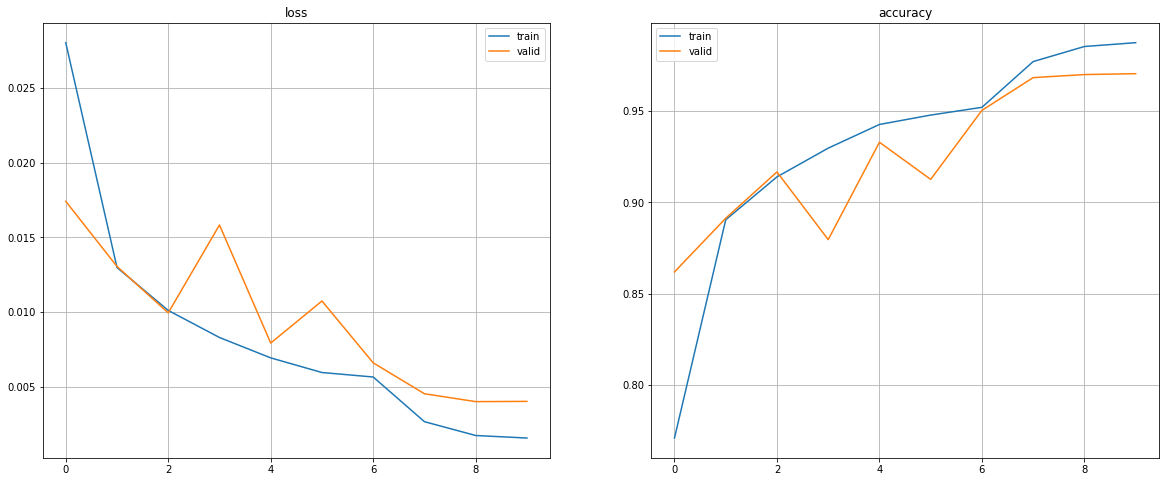

In [23]:
plot_metrics(losses, accuracies)

In [24]:
create_submission(model, dataloader['test'], files, classes)

  0%|          | 0/31 [00:00<?, ?it/s]

# EfficientNet

In [25]:
model = torchvision.models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features,
                                len(full_dataset.classes))
model = model.to(device)

In [26]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, losses, accuracies = train(model, loss, optimizer, epochs=10,
                                  scheduler=scheduler)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

Phase train::   0%|          | 0/524 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/131 [00:00<?, ?it/s]

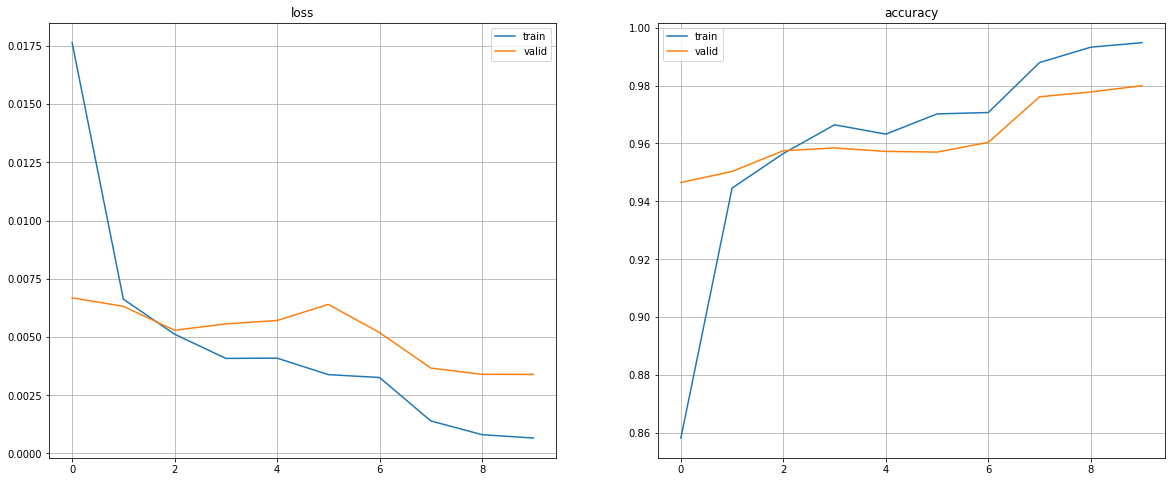

In [27]:
plot_metrics(losses, accuracies)

In [28]:
create_submission(model, dataloader['test'], files, classes)

  0%|          | 0/31 [00:00<?, ?it/s]

# Kaggle

368	Тарас_Михайлюк_287328882 0.99362